In [1]:
!pip install opendatasets timm lightning --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 31.1 MB/s eta 0:00:00


## Download the dataset from kaggle

In [2]:
import opendatasets as od

# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data'
od.download(dataset)

100%|██████████| 2.29G/2.29G [00:17<00:00, 141MB/s]


## Import the necessary libraries

In [14]:
# custom modules
%load_ext autoreload
%autoreload 2
import utilities
import model_functions
import model_factory

#lightning modules and callbacks
import lightning_data
import lightning_model
import train_info
import learning_curves
import confusion_matrix

import os

# timm models
import timm

# torch modules (temporarily)
import torch.nn as nn
import torch
# pytorch lightning (for checkpointing callbacks)
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mount GDrive partition to store checkpoints

In [4]:
# necessary, as checkpoints will be saved on GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Create the model to be trained with Pytorch Lightning

In [5]:
# specify here the model configuration
arch_name = 'resnet50'
classifier_name = 'linear'
classifier_type = model_factory.get_linear_classifer if classifier_name == 'linear' else model_factory.get_simple_non_linear_classifier
layers_version = 'classifier'
n_epochs = 10

# create the model
model, config = model_factory.get_model(arch_name, classifier_type, layers_version, n_epochs=n_epochs)

# set checkpoint path for this specific model configuration
# so that each model will be saved in a different folder
checkpoint_path = os.path.join('/content/drive/MyDrive/model_checkpoints/', arch_name, classifier_name, layers_version)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

23,512,130 total parameters.
4,098 trainable parameters.


In [6]:
checkpoint_path

'/content/drive/MyDrive/model_checkpoints/resnet50/linear/classifier'

## Set up the Pytorch Lightning modules and callbacks

In [10]:
# dataloader
pneumonia_data = lightning_data.PneumoniaDataModule(config)
# lightning module
pneumonia_model = lightning_model.PneumoniaModel(config,model)

# callback to print training info
training_info_callback = train_info.PrintTrainingInfoCallback()
# callback to show learning curves after training is done
learning_curves_callback = learning_curves.PlotLearningCurvesCallback()
# callback to show confusion matrix after test is done
conf_matrix_callback = confusion_matrix.PlotConfusionMatrixCallback()
#callback to track training times
timer = pl.callbacks.Timer()
# store the metrics in a csv format
logger = CSVLogger(save_dir = checkpoint_path, name="logs")

# callback to save the best model found during training
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=checkpoint_path, # checkpoints are saved to GDrive, in case runtime disconnects
    monitor="val_acc",
    mode='max',
    save_top_k=1,
    verbose=True,
    save_last = True, # save last model (to restore in case runtime disconnects)
    enable_version_counter=False
    )

callbacks = [training_info_callback,learning_curves_callback,conf_matrix_callback,checkpoint_callback,timer]

# create the trainer
trainer = pl.Trainer(
        max_epochs=config['n_epochs'],
        log_every_n_steps=1,
        callbacks = callbacks,
        logger = logger
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


CPU cores: 2, Device: cuda, GPU: Tesla T4


## Training

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/drive/MyDrive/model_checkpoints/resnet50/linear/classifier exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params
--------------------------------------
0 | model     | ResNet  | 23.5 M
1 | criterion | NLLLoss | 0     
--------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 37: 'val_acc' reached 52.26860 (best 52.26860), saving model to '/content/drive/MyDrive/model_checkpoints/resnet50/linear/classifier/epoch=0-step=37.ckpt' as top 1


Epoch: 001
	Train Loss: 0.5528, Train Accuracy: 83.86%
	Val Loss: 0.6626, Val Accuracy: 52.27%
	Elapsed time: 0h 2m 15s, Remaining Time: 0h 20m 13s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 74: 'val_acc' reached 82.21416 (best 82.21416), saving model to '/content/drive/MyDrive/model_checkpoints/resnet50/linear/classifier/epoch=1-step=74.ckpt' as top 1


Epoch: 002
	Train Loss: 0.4027, Train Accuracy: 88.47%
	Val Loss: 0.4499, Val Accuracy: 82.21%
	Elapsed time: 0h 4m 22s, Remaining Time: 0h 17m 26s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 111: 'val_acc' was not in top 1


Epoch: 003
	Train Loss: 0.3476, Train Accuracy: 88.64%
	Val Loss: 0.4369, Val Accuracy: 79.85%
	Elapsed time: 0h 6m 27s, Remaining Time: 0h 15m 2s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 148: 'val_acc' reached 84.93648 (best 84.93648), saving model to '/content/drive/MyDrive/model_checkpoints/resnet50/linear/classifier/epoch=3-step=148.ckpt' as top 1


Epoch: 004
	Train Loss: 0.3071, Train Accuracy: 89.90%
	Val Loss: 0.3519, Val Accuracy: 84.94%
	Elapsed time: 0h 8m 32s, Remaining Time: 0h 12m 48s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 185: 'val_acc' reached 85.66243 (best 85.66243), saving model to '/content/drive/MyDrive/model_checkpoints/resnet50/linear/classifier/epoch=4-step=185.ckpt' as top 1


Epoch: 005
	Train Loss: 0.2859, Train Accuracy: 90.61%
	Val Loss: 0.3305, Val Accuracy: 85.66%
	Elapsed time: 0h 10m 37s, Remaining Time: 0h 10m 37s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 222: 'val_acc' was not in top 1


Epoch: 006
	Train Loss: 0.2730, Train Accuracy: 90.33%
	Val Loss: 0.3263, Val Accuracy: 85.48%
	Elapsed time: 0h 12m 42s, Remaining Time: 0h 8m 28s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 259: 'val_acc' reached 89.11071 (best 89.11071), saving model to '/content/drive/MyDrive/model_checkpoints/resnet50/linear/classifier/epoch=6-step=259.ckpt' as top 1


Epoch: 007
	Train Loss: 0.2681, Train Accuracy: 89.97%
	Val Loss: 0.2768, Val Accuracy: 89.11%
	Elapsed time: 0h 14m 46s, Remaining Time: 0h 6m 20s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 296: 'val_acc' was not in top 1


Epoch: 008
	Train Loss: 0.2573, Train Accuracy: 91.30%
	Val Loss: 0.3059, Val Accuracy: 87.30%
	Elapsed time: 0h 16m 50s, Remaining Time: 0h 4m 12s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 333: 'val_acc' was not in top 1


Epoch: 009
	Train Loss: 0.2456, Train Accuracy: 91.47%
	Val Loss: 0.2920, Val Accuracy: 87.84%
	Elapsed time: 0h 18m 59s, Remaining Time: 0h 2m 7s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 370: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch: 010
	Train Loss: 0.2404, Train Accuracy: 91.51%
	Val Loss: 0.3174, Val Accuracy: 86.75%
	Elapsed time: 0h 21m 5s, Remaining Time: 0h 0m 0s


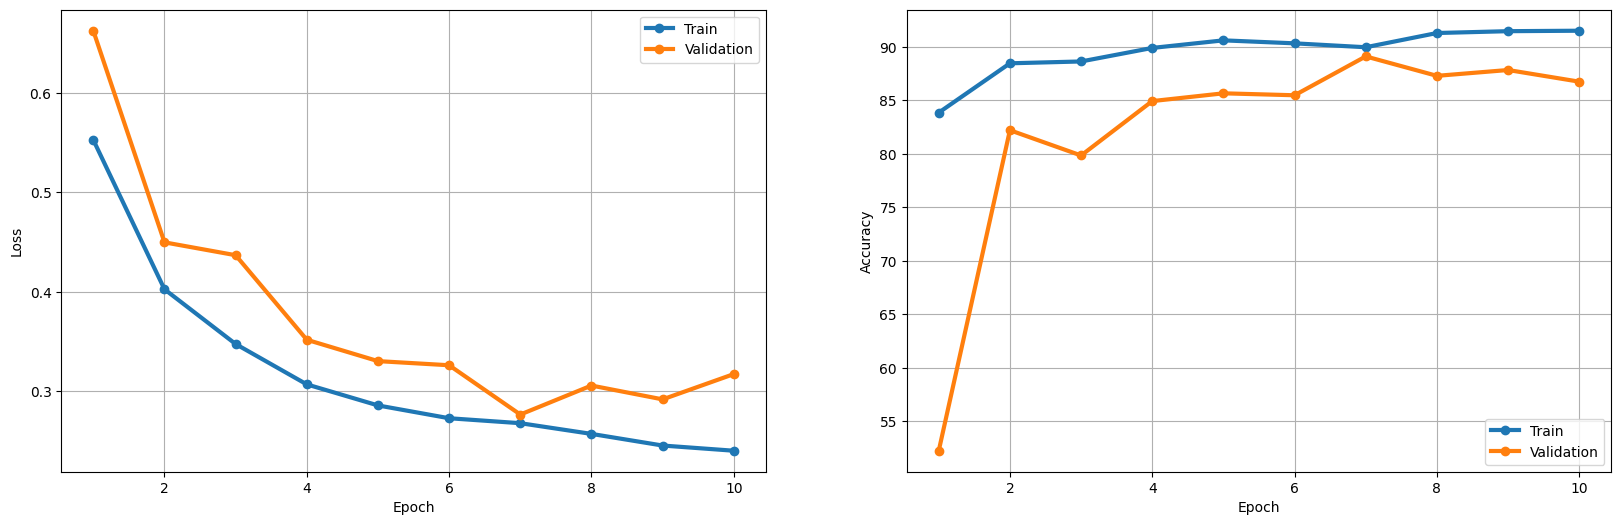

In [11]:
# uncomment this to restore training from last saved checkpoint (in case something went wrong)
#trainer.fit(pneumonia_model, datamodule=pneumonia_data, ckpt_path=checkpoint_path+"/last.ckpt")
trainer.fit(pneumonia_model, datamodule=pneumonia_data)

## Test

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

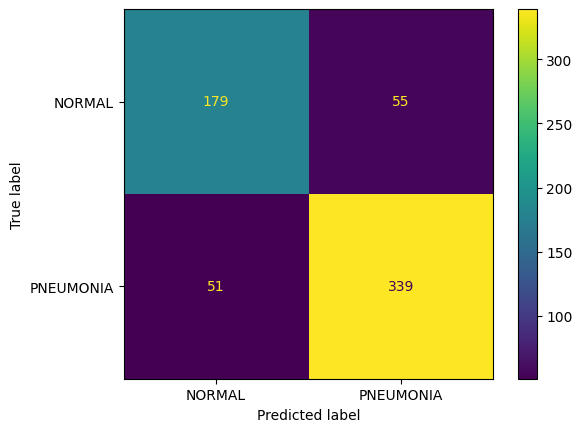

[{}]

In [12]:
# retrieve the best model from checkpoints
best_model_path = checkpoint_callback.best_model_path
best_model = lightning_model.PneumoniaModel.load_from_checkpoint(best_model_path, h=config, model=model)
pneumonia_model = best_model

# test the best model
trainer.test(pneumonia_model, datamodule=pneumonia_data)
#trainer.test(ckpt_path="best", datamodule=pneumonia_data) # alternatively, to test the best model directly

In [13]:
print(f"Test accuracy: {pneumonia_model.test_acc*100:.2f}%")
print(f"Precision: {pneumonia_model.test_precision*100:.2f}%")
print(f"Recall: {pneumonia_model.test_recall*100:.2f}%")
print(f"F1-score: {pneumonia_model.test_f1*100:.2f}%")

Test accuracy: 83.15%
Precision: 86.04%
Recall: 86.92%
F1-score: 86.48%


## Retrieve training loss and accuracy

In [19]:
# to retrieve training info
ckpt = torch.load(checkpoint_path+"/epoch=6-step=259.ckpt")
ckpt['callbacks']['PlotLearningCurvesCallback']

{'train_losses': [array(0.552838, dtype=float32),
  array(0.40268335, dtype=float32),
  array(0.3476332, dtype=float32),
  array(0.30706716, dtype=float32),
  array(0.2859227, dtype=float32),
  array(0.27303812, dtype=float32),
  array(0.26806656, dtype=float32)],
 'train_accs': [array(83.85852, dtype=float32),
  array(88.46731, dtype=float32),
  array(88.6388, dtype=float32),
  array(89.903534, dtype=float32),
  array(90.61093, dtype=float32),
  array(90.33226, dtype=float32),
  array(89.96784, dtype=float32)],
 'val_losses': [array(0.6626038, dtype=float32),
  array(0.44986653, dtype=float32),
  array(0.43693402, dtype=float32),
  array(0.35193342, dtype=float32),
  array(0.33046353, dtype=float32),
  array(0.3263037, dtype=float32),
  array(0.2767585, dtype=float32)],
 'val_accs': [array(52.268604, dtype=float32),
  array(82.21416, dtype=float32),
  array(79.85481, dtype=float32),
  array(84.93648, dtype=float32),
  array(85.66243, dtype=float32),
  array(85.48094, dtype=float32),
 

In [20]:
# time elapsed in seconds to 'train' and 'validate'
ckpt['callbacks']['Timer']['time_elapsed']

{'train': 877.5338036420001,
 'sanity_check': 0,
 'validate': 10.822792628999878,
 'test': 0,
 'predict': 0}

## Apply Grad-CAM XAI method

In [ ]:
!pip -q install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#best_model_path = checkpoint_callback.best_model_path # if same session, this will retrieve the path for you
best_model_path = checkpoint_path + "/epoch={}-step={}.ckpt" # replace {} with epoch and step of best model
best_model = lightning_model.PneumoniaModel.load_from_checkpoint(best_model_path, h=config, model=model)
pneumonia_model = best_model

In [ ]:
# extract the model from lightning module
model_lightning = pneumonia_model.model.eval().cpu()
# get the name of the architecture (used later)
model_lightning_name = model_lightning.default_cfg['architecture']

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

In [ ]:
instance_name = 'xray.jpeg' # name of the image instance we want to explain with Grad-CAM

img = np.array(Image.open(instance_name).convert('RGB'))
img = cv2.resize(img, (config['image_size'], config['image_size']))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=config['mean'], std=config['std'])

In [ ]:
# retrieve the proper feature layer to be used for explanation
if model_lightning_name == 'legacy_xception':
  target_layers = [model_lightning.conv4]
elif model_lightning_name == 'densenet121':
  target_layers = [model_lightning.features.denseblock4.denselayer16]
elif model_lightning_name == 'resnet50':
  target_layers = [model_lightning.layer4[-1]]


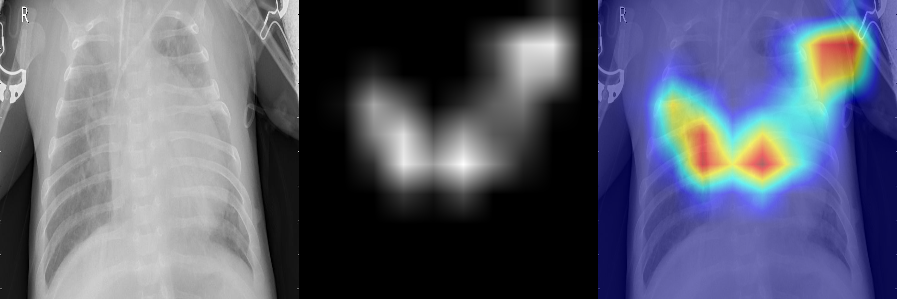

In [ ]:
with GradCAM(model=model_lightning, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor) # activation map generated for the top scoring class
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)